# Image Label Dataset builder code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import time as tm
import random
import math
import pandas as pd
from PIL import Image
from scipy.spatial.distance import pdist, squareform
import os
sym.init_printing(pretty_print = True)

strainDatabase = {}

In [3]:
class point: #Create a point, stores time and value at time.
    def __init__(self, value, time, drop):
        self.time = time
        self.drop = drop
        self.value = value
        self.alive = True
        self.dropval = value
        self.his = []
        self.dhis = []
         
    @property  
    def prop(self):
        return [self.time, self.value, self.drop]  
    @property    
    def isOdd(self): #Check if value is negative
        if self.time % 2 == 1: return True
        else: return False

def hysterisFilter(points, gateSize = 0.1):
    cleanedPoints = []
    for i in range(len(points)-1):
        if abs(points[i]-points[i+1]) >= gateSize:
            cleanedPoints.append(points[i])
    cleanedPoints.append(points[len(points)-1])
    
    return cleanedPoints

def peakValleyFilter(points):
    cleanedPoints = []
    cleanedPoints.append(points[0])
    for i in range(1,len(points)-1):
        if (points[i] > points[i+1] and points[i] > points[i-1]) or \
        (points[i] < points[i+1] and points[i] < points[i-1]):
            cleanedPoints.append(points[i])
    cleanedPoints.append(points[len(points)-1])
    
    return cleanedPoints

def discretize(points, roundVal = 3):
    cleanedPoints = []
    for p in points:
        cleanedPoints.append(round(p, roundVal))
        
    return cleanedPoints

def shifter(points):
    max = np.argmax(points)
    shifted = []
    for i in range(max, len(points)):
        shifted.append(points[i])
    for i in range(max):
        shifted.append(points[i])
        
    return shifted

def isBlocked(p,points):
    for i in range (p.time-1):
        if p.drop in points[i].his:
            #print('Blocked by', points[i].prop)
            return True
    return False

def dropMove(points):
    for p in points:
        #print('Drop Start:', p.time)
        
        #1. Check if the drop is not blocked by another drop path. 
        while p.alive == True:
            if isBlocked(p,points) == True: 
                p.alive = False
            
        #2. Check if drop is the last one, kill directly.
            elif p.time == len(points) - 1:
                p.alive = False           
                
        #3. Check if drop has reached end and is ready to roll off.
            elif (p.drop+2) >= len(points) and p.time != len(points)-2:
                if p.isOdd == False: p.drop = p.drop + 2
                else: p.drop = p.drop + 1
                p.his.append(p.drop)
                p.alive = False
        #5. Second last drop is always murdered by the first drop in a loop.    
            elif p.time == len(points)-2:
                    #print('Murdered by', points[0].prop)
                    p.drop = p.drop + 1
                    p.alive = False
                    
        #6. Drops in even positions should fall with greater negatives.
            elif p.isOdd == False:
                if p.value > points[p.drop+2].value:
                    p.drop = p.drop + 2
                else: 
                    #print('Murdered by', points[p.drop+2].prop)
                    p.drop = p.drop + 1
                    p.alive = False
       
        #7. Drops in odd positions should fall with greater positives.
            else:
                if p.value < points[p.drop+2].value:
                    p.drop = p.drop + 2
                else:
                    #print('Murdered by', points[p.drop+2].prop)
                    p.drop = p.drop + 1
                    p.alive = False
                    
        #8. Check if a falling drop hits a roof, and log this change in drop fall.            
            if p.drop+1 < len(points) and p.alive == True \
            and ((points[p.drop+1].value < points[p.drop-1].dropval and p.isOdd == False) \
            or (points[p.drop+1].value > points[p.drop-1].dropval and p.isOdd == True)):
                p.dropval = points[p.drop+1].value 
                p.his.append(p.drop)
                p.dhis.append(p.dropval)                
        #print('Movement history:', p.his, '\nDrop Value:', p.dhis, '\n')
        
    return points

def generate(length=200):
    y = 0
    result = []
    for _ in range(length):
        y += np.random.normal(scale=1)
        result.append(y)
        
    return np.array(result) 

def findLoops(points):
    results,pairs = [],[]
    for i in range(len(points)): 
        results.append(points[i].drop)
    for i in range(len(results)): 
        for j in range(i+1, len(results)):  
            if (results[i] == results[j]): 
                pairs.append([i,j])
                
    return pairs 

def setUpTable(points,pairs):
    smin, smax, smean, samp, sdel = [],[],[],[],[]
    for i in range(len(pairs)):
        smin.append(min(points[pairs[i][0]].value,points[pairs[i][1]].value)) 
        smax.append(max(points[pairs[i][0]].value,points[pairs[i][1]].value))
        smean.append((points[pairs[i][1]].value + points[pairs[i][0]].value) / 2)
        samp.append((smax[i] - smin[i]) / 2)
        sdel.append(2*samp[i])
        
    return [smin, smax, smean, samp, sdel]

def strainDatabaseUpdate(esp, life):
    strainDatabase[esp] = life
    return None
    
def strainDatabaseFind(esp):
    if esp in strainDatabase:
        life = strainDatabase[esp]
        return True, life
    else:
        return False, -1
    
def mySolve(eq, N):
    key = 1000
    pos = 100
    solution = eq.subs({N : key})
    
    while abs(solution) > 10**-12:
        shift = key/pos
        oldSol = solution
        solution = eq.subs({N : key})
        
        #Drop shift value by factor of 10 to increase accuracy towards approaching solution
        if (oldSol < 0 and solution > 0) or (oldSol > 0 and solution < 0): pos = pos*10
        #print(solution)
        if solution > 0:
            key = key - shift
        else: 
            key = key + shift

    return key

def fatigueList(sresults, substitutions):
    fatigue = []
    N, sig, D, E, esp = sym.symbols('N σ D E Δε')
    f = esp - (3.5*(sig/E)*N**(-0.12) + D**(0.6)*N**(-0.6))
    #To display equation
    #display(f)

    for e in sresults[4]:
        e = round(e,2)
        #print(e)
        subs = {sig:substitutions[0], D:substitutions[1], E:substitutions[2], esp:e*10**-3}
        es = e*10**-3
        start_time = tm.time()
        exists = strainDatabaseFind(es)
        if exists[0] == False:
            fa = f.subs(subs)
            #Use to view substitutions, especially if execution takes too long.
            #print(subs)
            life = mySolve(fa, N)
            strainDatabaseUpdate(es, life)
        else:
            #print("Found ",e," in Database!")
            life = exists[1]
            
        fatigue.append(life)
        #Use to print time taken to solve
        #print("--- %s seconds ---" % (tm.time() - start_time))

    return fatigue

def runner(p, substitutions):    
    clean = peakValleyFilter(shifter(discretize(peakValleyFilter(hysterisFilter(p)))))
    
    points = []
    for i in range(len(clean)): points.append(point(clean[i],i,i))    
    cleanUp = dropMove(points)
    sresults = setUpTable(cleanUp, findLoops(cleanUp))
    
    D = 0
    for fa in fatigueList(sresults, substitutions): D = D + 1/fa
    I = 1/D

    return I

def populate(length=100):
    #p = generate(random.randint(10,1000))    #This gets replaced by actual data
    p = generate(length)
    sig = 430*10**6
    psi = .65
    D = math.log(1/(1-psi))
    E = 205*10**9 
    substitutions = [sig, D, E]

    results = runner(p, substitutions)
    
    return p, sig, D, E, results

def rec_plot(s, path):
    eps=0.4
    steps=40
    N = s.size
    S = np.repeat(s[None,:], N, axis=0)
    Z = np.floor(np.abs(S-S.T)/eps)
    Z[Z>steps] = steps
    img = Image.fromarray(np.uint8(Z * 255), 'L')
    img = img.resize((100,100), Image.ANTIALIAS)
    img.save(path)
    

def project(s, path):
    length = len(s)
    x = np.arange(0, length+1, 1)
    y = s
    y = np.append(y, y[0])
    r,t = [y, 2*np.pi*x/(len(x)-1)]
    with plt.rc_context({"figure.figsize": [10,10]}):
        fig = plt.figure('Circular')
        plt.subplot(projection='polar')
        plt.plot(t,r, color='black')
        plt.axis('off')  
        plt.savefig(path, bbox_inches='tight')
        plt.clf()
        
def cleanRec(s, path):
    s = np.array(peakValleyFilter(shifter(discretize(peakValleyFilter(hysterisFilter(s))))))
    rec_plot(s, path)

def label(life):
    bin_size = 1
    lab = int(int(life)/bin_size)*bin_size
    folder = 'TestV5'
    file_ext = '.png'
    filename = str(lab)
    conversion = ['recplot','projection','cleanrec']
    path = [None]*3
    
    for i in range(3):
        path[i] = '%s/%s/%s%s' % (folder, conversion[i], filename, file_ext)
        uniq = 1
        while os.path.exists(path[i]):
            path[i] = '%s/%s/%s_%d%s' % (folder, conversion[i], filename, uniq, file_ext)
            uniq += 1
        
    return path

Iteration:  0
Number of approximate solver sequences for size 100 : 401.4627133240644
Runtime: 12.7637300491333 seconds
Iteration:  1
Number of approximate solver sequences for size 100 : 2668.0886639657842
Runtime: 14.963432550430298 seconds
Iteration:  2
Number of approximate solver sequences for size 100 : 1792.685989521553
Runtime: 9.948302268981934 seconds
Iteration:  3
Number of approximate solver sequences for size 100 : 3636.3880733361207
Runtime: 8.828266859054565 seconds
Iteration:  4
Number of approximate solver sequences for size 100 : 1264.4567649750682
Runtime: 6.634198904037476 seconds
Iteration:  5
Number of approximate solver sequences for size 100 : 3324.871363307388
Runtime: 4.591397762298584 seconds
Iteration:  6
Number of approximate solver sequences for size 100 : 2867.7289808097676
Runtime: 21.1174418926239 seconds
Iteration:  7
Number of approximate solver sequences for size 100 : 3401.120162120265
Runtime: 15.468158960342407 seconds
Iteration:  8
Number of appr

Iteration:  67
Number of approximate solver sequences for size 100 : 1847.00386117084
Runtime: 1.5391185283660889 seconds
Iteration:  68
Number of approximate solver sequences for size 100 : 4781.40975556333
Runtime: 0.6136665344238281 seconds
Iteration:  69
Number of approximate solver sequences for size 100 : 1333.8154734854288
Runtime: 0.3187994956970215 seconds
Iteration:  70
Number of approximate solver sequences for size 100 : 4099.4478024192895
Runtime: 1.0713882446289062 seconds
Iteration:  71
Number of approximate solver sequences for size 100 : 1153.2513184133818
Runtime: 0.3847775459289551 seconds
Iteration:  72
Number of approximate solver sequences for size 100 : 941.3867768174712
Runtime: 2.131779909133911 seconds
Iteration:  73
Number of approximate solver sequences for size 100 : 3316.224203362428
Runtime: 0.9064829349517822 seconds
Iteration:  74
Number of approximate solver sequences for size 100 : 1852.818512334966
Runtime: 0.40976548194885254 seconds
Iteration:  75


Iteration:  134
Number of approximate solver sequences for size 100 : 4145.862051862235
Runtime: 0.6056528091430664 seconds
Iteration:  135
Number of approximate solver sequences for size 100 : 1801.0415553012963
Runtime: 0.510709285736084 seconds
Iteration:  136
Number of approximate solver sequences for size 100 : 3373.9748514781545
Runtime: 0.5057084560394287 seconds
Iteration:  137
Number of approximate solver sequences for size 100 : 5728.128083205675
Runtime: 0.5456874370574951 seconds
Iteration:  138
Number of approximate solver sequences for size 100 : 1082.5845247402424
Runtime: 0.48172450065612793 seconds
Iteration:  139
Number of approximate solver sequences for size 100 : 1455.4868223064868
Runtime: 0.4147636890411377 seconds
Iteration:  140
Number of approximate solver sequences for size 100 : 410.1915017610436
Runtime: 1.333235740661621 seconds
Iteration:  141
Number of approximate solver sequences for size 100 : 1727.8094949163292
Runtime: 0.9334666728973389 seconds
Iter

Iteration:  200
Number of approximate solver sequences for size 100 : 689.4841847009062
Runtime: 0.5936617851257324 seconds
Iteration:  201
Number of approximate solver sequences for size 100 : 3057.0583631270074
Runtime: 0.6916043758392334 seconds
Iteration:  202
Number of approximate solver sequences for size 100 : 2555.9022863699233
Runtime: 0.25185585021972656 seconds
Iteration:  203
Number of approximate solver sequences for size 100 : 1517.6659195234824
Runtime: 0.40577006340026855 seconds
Iteration:  204
Number of approximate solver sequences for size 100 : 3779.051890974528
Runtime: 0.41475939750671387 seconds
Iteration:  205
Number of approximate solver sequences for size 100 : 1038.6660016185867
Runtime: 0.43774986267089844 seconds
Iteration:  206
Number of approximate solver sequences for size 100 : 2446.030489256532
Runtime: 0.7095930576324463 seconds
Iteration:  207
Number of approximate solver sequences for size 100 : 1728.4765415938498
Runtime: 0.4747292995452881 seconds

Iteration:  266
Number of approximate solver sequences for size 100 : 1682.5349857357899
Runtime: 0.989434003829956 seconds
Iteration:  267
Number of approximate solver sequences for size 100 : 1436.480862086399
Runtime: 1.8069658279418945 seconds
Iteration:  268
Number of approximate solver sequences for size 100 : 1627.0746287282236
Runtime: 1.187866449356079 seconds
Iteration:  269
Number of approximate solver sequences for size 100 : 966.7863058186668
Runtime: 0.6836080551147461 seconds
Iteration:  270
Number of approximate solver sequences for size 100 : 1594.024415031995
Runtime: 0.7495720386505127 seconds
Iteration:  271
Number of approximate solver sequences for size 100 : 1989.9292679657729
Runtime: 0.7535674571990967 seconds
Iteration:  272
Number of approximate solver sequences for size 100 : 2263.2912691656957
Runtime: 1.8739256858825684 seconds
Iteration:  273
Number of approximate solver sequences for size 100 : 1424.7870816262568
Runtime: 0.20888066291809082 seconds
Iter

Iteration:  332
Number of approximate solver sequences for size 100 : 1525.6747063200887
Runtime: 0.39577293395996094 seconds
Iteration:  333
Number of approximate solver sequences for size 100 : 1268.2081373091448
Runtime: 0.6126770973205566 seconds
Iteration:  334
Number of approximate solver sequences for size 100 : 1034.4193060002399
Runtime: 1.2772696018218994 seconds
Iteration:  335
Number of approximate solver sequences for size 100 : 3998.7014995829763
Runtime: 1.1873185634613037 seconds
Iteration:  336
Number of approximate solver sequences for size 100 : 1198.8182177124272
Runtime: 0.44774293899536133 seconds
Iteration:  337
Number of approximate solver sequences for size 100 : 3196.8559848050136
Runtime: 0.4447445869445801 seconds
Iteration:  338
Number of approximate solver sequences for size 100 : 1842.6357439803144
Runtime: 0.40177202224731445 seconds
Iteration:  339
Number of approximate solver sequences for size 100 : 2891.798288396372
Runtime: 0.40176987648010254 secon

Iteration:  398
Number of approximate solver sequences for size 100 : 2712.6349341647297
Runtime: 0.2668471336364746 seconds
Iteration:  399
Number of approximate solver sequences for size 100 : 809.4673662483883
Runtime: 0.5047125816345215 seconds
Iteration:  400
Number of approximate solver sequences for size 100 : 689.6562614793704
Runtime: 0.5496842861175537 seconds
Iteration:  401
Number of approximate solver sequences for size 100 : 2967.597319341104
Runtime: 0.19389104843139648 seconds
Iteration:  402
Number of approximate solver sequences for size 100 : 1874.869821484089
Runtime: 0.2568516731262207 seconds
Iteration:  403
Number of approximate solver sequences for size 100 : 891.7308017429418
Runtime: 0.4777250289916992 seconds
Iteration:  404
Number of approximate solver sequences for size 100 : 2675.1208337762314
Runtime: 1.3072521686553955 seconds
Iteration:  405
Number of approximate solver sequences for size 100 : 2072.6693887637302
Runtime: 0.5896615982055664 seconds
Iter

Iteration:  465
Number of approximate solver sequences for size 100 : 2940.2818557860446
Runtime: 0.19089126586914062 seconds
Iteration:  466
Number of approximate solver sequences for size 100 : 760.9723652456205
Runtime: 0.7145893573760986 seconds
Iteration:  467
Number of approximate solver sequences for size 100 : 2033.2418053338056
Runtime: 0.2528564929962158 seconds
Iteration:  468
Number of approximate solver sequences for size 100 : 2299.0869576932732
Runtime: 0.17389965057373047 seconds
Iteration:  469
Number of approximate solver sequences for size 100 : 3042.834283432499
Runtime: 0.49671483039855957 seconds
Iteration:  470
Number of approximate solver sequences for size 100 : 2032.11826387378
Runtime: 0.6536252498626709 seconds
Iteration:  471
Number of approximate solver sequences for size 100 : 2630.2705382359377
Runtime: 0.4347522258758545 seconds
Iteration:  472
Number of approximate solver sequences for size 100 : 6653.865951737576
Runtime: 0.6276416778564453 seconds
It

Iteration:  531
Number of approximate solver sequences for size 100 : 610.3873443310264
Runtime: 0.37978196144104004 seconds
Iteration:  532
Number of approximate solver sequences for size 100 : 497.00221937195846
Runtime: 0.8455140590667725 seconds
Iteration:  533
Number of approximate solver sequences for size 100 : 1853.0328859536212
Runtime: 0.5007140636444092 seconds
Iteration:  534
Number of approximate solver sequences for size 100 : 1094.5455272682154
Runtime: 0.4127621650695801 seconds
Iteration:  535
Number of approximate solver sequences for size 100 : 1537.9547006739608
Runtime: 0.3368074893951416 seconds
Iteration:  536
Number of approximate solver sequences for size 100 : 1058.1347364954618
Runtime: 0.3867788314819336 seconds
Iteration:  537
Number of approximate solver sequences for size 100 : 9440.981283543768
Runtime: 0.713592529296875 seconds
Iteration:  538
Number of approximate solver sequences for size 100 : 1405.5688821893443
Runtime: 0.188889741897583 seconds
Ite

Iteration:  597
Number of approximate solver sequences for size 100 : 2336.2334457038774
Runtime: 0.4427449703216553 seconds
Iteration:  598
Number of approximate solver sequences for size 100 : 1557.466214669876
Runtime: 0.38977599143981934 seconds
Iteration:  599
Number of approximate solver sequences for size 100 : 905.4799288290291
Runtime: 0.9464578628540039 seconds
Iteration:  600
Number of approximate solver sequences for size 100 : 1330.9875105049537
Runtime: 0.4407479763031006 seconds
Iteration:  601
Number of approximate solver sequences for size 100 : 1689.5126738089077
Runtime: 0.7705585956573486 seconds
Iteration:  602
Number of approximate solver sequences for size 100 : 3380.1253379716177
Runtime: 0.19688677787780762 seconds
Iteration:  603
Number of approximate solver sequences for size 100 : 2595.5543977264406
Runtime: 0.19588947296142578 seconds
Iteration:  604
Number of approximate solver sequences for size 100 : 962.2970015686442
Runtime: 0.18589186668395996 seconds

Iteration:  663
Number of approximate solver sequences for size 100 : 4830.27438029705
Runtime: 0.41576218605041504 seconds
Iteration:  664
Number of approximate solver sequences for size 100 : 1366.3977515729316
Runtime: 0.19688868522644043 seconds
Iteration:  665
Number of approximate solver sequences for size 100 : 612.7871222671371
Runtime: 0.4867208003997803 seconds
Iteration:  666
Number of approximate solver sequences for size 100 : 1404.0955860650201
Runtime: 0.47272825241088867 seconds
Iteration:  667
Number of approximate solver sequences for size 100 : 1964.613121878175
Runtime: 0.45374035835266113 seconds
Iteration:  668
Number of approximate solver sequences for size 100 : 1522.6280846689024
Runtime: 0.7556314468383789 seconds
Iteration:  669
Number of approximate solver sequences for size 100 : 3416.0578059546942
Runtime: 0.3308107852935791 seconds
Iteration:  670
Number of approximate solver sequences for size 100 : 1036.7139967877774
Runtime: 0.4367496967315674 seconds


Iteration:  729
Number of approximate solver sequences for size 100 : 917.1612000396843
Runtime: 0.5087087154388428 seconds
Iteration:  730
Number of approximate solver sequences for size 100 : 605.9211253223983
Runtime: 0.9814355373382568 seconds
Iteration:  731
Number of approximate solver sequences for size 100 : 1666.6217301123443
Runtime: 0.4607362747192383 seconds
Iteration:  732
Number of approximate solver sequences for size 100 : 946.9331619214638
Runtime: 0.4287562370300293 seconds
Iteration:  733
Number of approximate solver sequences for size 100 : 1632.1567188098902
Runtime: 0.20488262176513672 seconds
Iteration:  734
Number of approximate solver sequences for size 100 : 3147.0814433453957
Runtime: 0.49871826171875 seconds
Iteration:  735
Number of approximate solver sequences for size 100 : 11659.100012946952
Runtime: 0.17389631271362305 seconds
Iteration:  736
Number of approximate solver sequences for size 100 : 1547.3761993499227
Runtime: 0.862506628036499 seconds
Iter

Iteration:  795
Number of approximate solver sequences for size 100 : 1067.5648534942227
Runtime: 0.39777135848999023 seconds
Iteration:  796
Number of approximate solver sequences for size 100 : 1269.7815739949203
Runtime: 0.49172139167785645 seconds
Iteration:  797
Number of approximate solver sequences for size 100 : 1398.8461421280501
Runtime: 0.5406875610351562 seconds
Iteration:  798
Number of approximate solver sequences for size 100 : 955.0546133000104
Runtime: 0.4187617301940918 seconds
Iteration:  799
Number of approximate solver sequences for size 100 : 1384.9466876170864
Runtime: 0.9494576454162598 seconds
Iteration:  800
Number of approximate solver sequences for size 100 : 3480.5575940264507
Runtime: 0.4847226142883301 seconds
Iteration:  801
Number of approximate solver sequences for size 100 : 2983.68320927199
Runtime: 0.16790342330932617 seconds
Iteration:  802
Number of approximate solver sequences for size 100 : 2682.6378939559427
Runtime: 0.19588494300842285 seconds

Iteration:  861
Number of approximate solver sequences for size 100 : 1282.7461717081592
Runtime: 0.5486843585968018 seconds
Iteration:  862
Number of approximate solver sequences for size 100 : 1841.2234414755735
Runtime: 0.20188498497009277 seconds
Iteration:  863
Number of approximate solver sequences for size 100 : 664.8477719701528
Runtime: 0.525698184967041 seconds
Iteration:  864
Number of approximate solver sequences for size 100 : 1054.575744723486
Runtime: 0.43375325202941895 seconds
Iteration:  865
Number of approximate solver sequences for size 100 : 2992.471890411124
Runtime: 0.5167043209075928 seconds
Iteration:  866
Number of approximate solver sequences for size 100 : 422.4925963749035
Runtime: 0.48272109031677246 seconds
Iteration:  867
Number of approximate solver sequences for size 100 : 1307.2050853430576
Runtime: 0.37978506088256836 seconds
Iteration:  868
Number of approximate solver sequences for size 100 : 759.588099926983
Runtime: 0.5366923809051514 seconds
Ite

Iteration:  927
Number of approximate solver sequences for size 100 : 1667.1404046378727
Runtime: 0.2648482322692871 seconds
Iteration:  928
Number of approximate solver sequences for size 100 : 1413.4065914902424
Runtime: 0.8635046482086182 seconds
Iteration:  929
Number of approximate solver sequences for size 100 : 844.9437085239548
Runtime: 0.18189620971679688 seconds
Iteration:  930
Number of approximate solver sequences for size 100 : 4073.378227458658
Runtime: 0.2018876075744629 seconds
Iteration:  931
Number of approximate solver sequences for size 100 : 955.2435410861498
Runtime: 0.1988832950592041 seconds
Iteration:  932
Number of approximate solver sequences for size 100 : 1349.4299137739006
Runtime: 0.19588780403137207 seconds
Iteration:  933
Number of approximate solver sequences for size 100 : 1244.7865903479053
Runtime: 0.6246414184570312 seconds
Iteration:  934
Number of approximate solver sequences for size 100 : 1998.4168145789274
Runtime: 0.18089675903320312 seconds


Iteration:  993
Number of approximate solver sequences for size 100 : 553.9233446280625
Runtime: 0.35379767417907715 seconds
Iteration:  994
Number of approximate solver sequences for size 100 : 3024.857257702583
Runtime: 0.552685022354126 seconds
Iteration:  995
Number of approximate solver sequences for size 100 : 1659.2172972799876
Runtime: 0.21987342834472656 seconds
Iteration:  996
Number of approximate solver sequences for size 100 : 734.5250041342375
Runtime: 0.39377713203430176 seconds
Iteration:  997
Number of approximate solver sequences for size 100 : 450.83222742076737
Runtime: 0.5776660442352295 seconds
Iteration:  998
Number of approximate solver sequences for size 100 : 1332.6592871734517
Runtime: 0.19189000129699707 seconds
Iteration:  999
Number of approximate solver sequences for size 100 : 5927.525241340963
Runtime: 0.18589377403259277 seconds


,0,1,2,3,4,5,6,7,8,9,...,97,98,99,Sig,D,E,Sequences,Rec-Plot,Projection,Clean-Rec-Plot
Data0,0.267685,1.943217,3.477681,4.108636,4.680048,6.298502,6.448877,9.201925,9.733761,10.800534,...,26.412489,26.293840,26.438625,430000000,1.049822,205000000000,401.462713,TestV5/recplot/401.png,TestV5/projection/401.png,TestV5/cleanrec/401.png
Data1,-1.058260,0.152500,1.692812,1.472525,-0.247199,-1.531950,-1.198382,-0.776154,1.422691,1.152606,...,-2.202035,-2.174682,-2.087166,430000000,1.049822,205000000000,2668.088664,TestV5/recplot/2668.png,TestV5/projection/2668.png,TestV5/cleanrec/2668.png
Data2,-0.286344,0.082778,-0.034037,0.505116,0.921869,1.255952,1.383695,1.722028,2.339093,1.694974,...,-6.464244,-5.940251,-6.042164,430000000,1.049822,205000000000,1792.685990,TestV5/recplot/1792.png,TestV5/projection/1792.png,TestV5/cleanrec/1792.png
Data3,1.187530,2.390906,-0.327906,-0.005635,-0.820847,-2.026042,-2.063068,-2.634397,-2.671833,-1.622533,...,0.725472,-0.165914,0.644327,430000000,1.049822,205000000000,3636.388073,TestV5/recplot/3636.png,TestV5/projection/3636.png,TestV5/cleanrec/3636.png
Data4,-0.840089,-1.583401,0.937544,0.054884,1.062020,0.892773,0.425231,0.375710,1.614867,1.583434,...,-12.803209,-13.264084,-14.139978,430000000,1.049822,205000000000,1264.456765,TestV5/recplot/1264.png,TestV5/projection/1264.png,TestV5/cleanrec/1264.png
Data5,2.012474,2.346121,2.643981,2.178102,1.521697,-0.307385,-0.841178,-1.099138,-0.305687,0.895331,...,-1.060537,-2.037242,-3.140368,430000000,1.049822,205000000000,3324.871363,TestV5/recplot/3324.png,TestV5/projection/3324.png,TestV5/cleanrec/3324.png
Data6,0.989451,0.312130,1.021233,1.304622,0.220001,-0.284765,0.255170,-0.921040,0.296777,0.699592,...,-5.201858,-4.599704,-5.187733,430000000,1.049822,205000000000,2867.728981,TestV5/recplot/2867.png,TestV5/projection/2867.png,TestV5/cleanrec/2867.png
Data7,1.243069,2.407287,3.757557,5.322336,6.352432,4.600354,4.882613,5.919504,6.333781,6.530001,...,4.478233,2.644957,2.504023,430000000,1.049822,205000000000,3401.120162,TestV5/recplot/3401.png,TestV5/projection/3401.png,TestV5/cleanrec/3401.png
Data8,0.309557,0.810525,0.131492,-0.031497,0.349395,1.066441,1.617494,1.546320,0.977097,1.116983,...,-11.520292,-11.173534,-10.977249,430000000,1.049822,205000000000,1324.215314,TestV5/recplot/1324.png,TestV5/projection/1324.png,TestV5/cleanrec/1324.png
Data9,0.501986,1.718035,1.241063,1.902253,2.967453,3.896559,3.620915,4.798042,4.718166,4.173631,...,21.126179,21.961898,23.137463,430000000,1.049822,205000000000,747.912564,TestV5/recplot/747.png,TestV5/projection/747.png,TestV5/cleanrec/747.png


<Figure size 720x720 with 0 Axes>

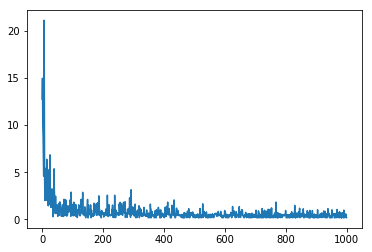

In [6]:
table = []
string = []
runtime = []
for i in range(1000):
    start_time = tm.time()
    store = populate(100)
    #clean = peakValleyFilter(shifter(discretize(peakValleyFilter(hysterisFilter(p)))))
    path = label(store[4])
    #print(path)
    rec_plot(store[0],path[0])
    project(store[0],path[1])
    cleanRec(store[0],path[2])
    
    print('Iteration: ',i)
    #display(store[0])
    #plt.plot(store[0])
    #plt.show()
    #display(img)
    print('Number of approximate solver sequences for size',len(store[0]),':', store[4])
    
    stri = 'Data' + str(i)
    arr = store[0].tolist()
    for j in range(1,5): arr.append(store[j])    
    arr.append(path[0])
    arr.append(path[1])
    arr.append(path[2])
    table.append(arr)
    string.append(stri)
    
    duration = tm.time() - start_time
    runtime.append(duration)
    print('Runtime: %s seconds' % (duration))
    
data = pd.DataFrame(table, index = string)
col = len(data.columns)
data.rename(columns={col-7: 'Sig', col-6: 'D', col-5: 'E', col-4: 'Sequences', col-3: 'Rec-Plot', col-2: 'Projection', col-1: 'Clean-Rec-Plot'}, inplace=True)
display(data)

plt.show()
plt.plot(runtime)
plt.show()

with open('TestVibsV5.csv', 'a') as fd:
    data.to_csv(fd, header=True)
    
#data.to_csv("Vibrations.csv")

In [7]:
#display(strainDatabase)
SD = pd.DataFrame.from_dict(strainDatabase, orient = 'index', columns=['Life'])
#display(SD)
SD.to_csv('TSDV5.csv', header=True)

In [8]:
vibData = pd.read_csv("TestVibsV5.csv", index_col=0)
display(vibData)
strainData = pd.read_csv("TSDV5.csv", index_col=0)
display(strainData)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,Sig,D,E,Sequences,Rec-Plot,Projection,Clean-Rec-Plot
Data0,0.267685,1.943217,3.477681,4.108636,4.680048,6.298502,6.448877,9.201925,9.733761,10.800534,...,26.412489,26.293840,26.438625,430000000,1.049822,205000000000,401.462713,TestV5/recplot/401.png,TestV5/projection/401.png,TestV5/cleanrec/401.png
Data1,-1.058260,0.152500,1.692812,1.472525,-0.247199,-1.531950,-1.198382,-0.776154,1.422691,1.152606,...,-2.202035,-2.174682,-2.087166,430000000,1.049822,205000000000,2668.088664,TestV5/recplot/2668.png,TestV5/projection/2668.png,TestV5/cleanrec/2668.png
Data2,-0.286344,0.082778,-0.034037,0.505116,0.921869,1.255952,1.383695,1.722028,2.339093,1.694974,...,-6.464244,-5.940251,-6.042164,430000000,1.049822,205000000000,1792.685990,TestV5/recplot/1792.png,TestV5/projection/1792.png,TestV5/cleanrec/1792.png
Data3,1.187530,2.390906,-0.327906,-0.005635,-0.820847,-2.026042,-2.063068,-2.634397,-2.671833,-1.622533,...,0.725472,-0.165914,0.644327,430000000,1.049822,205000000000,3636.388073,TestV5/recplot/3636.png,TestV5/projection/3636.png,TestV5/cleanrec/3636.png
Data4,-0.840089,-1.583401,0.937544,0.054884,1.062020,0.892773,0.425231,0.375710,1.614867,1.583434,...,-12.803209,-13.264084,-14.139978,430000000,1.049822,205000000000,1264.456765,TestV5/recplot/1264.png,TestV5/projection/1264.png,TestV5/cleanrec/1264.png
Data5,2.012474,2.346121,2.643981,2.178102,1.521697,-0.307385,-0.841178,-1.099138,-0.305687,0.895331,...,-1.060537,-2.037242,-3.140368,430000000,1.049822,205000000000,3324.871363,TestV5/recplot/3324.png,TestV5/projection/3324.png,TestV5/cleanrec/3324.png
Data6,0.989451,0.312130,1.021233,1.304622,0.220001,-0.284765,0.255170,-0.921040,0.296777,0.699592,...,-5.201858,-4.599704,-5.187733,430000000,1.049822,205000000000,2867.728981,TestV5/recplot/2867.png,TestV5/projection/2867.png,TestV5/cleanrec/2867.png
Data7,1.243069,2.407287,3.757557,5.322336,6.352432,4.600354,4.882613,5.919504,6.333781,6.530001,...,4.478233,2.644957,2.504023,430000000,1.049822,205000000000,3401.120162,TestV5/recplot/3401.png,TestV5/projection/3401.png,TestV5/cleanrec/3401.png
Data8,0.309557,0.810525,0.131492,-0.031497,0.349395,1.066441,1.617494,1.546320,0.977097,1.116983,...,-11.520292,-11.173534,-10.977249,430000000,1.049822,205000000000,1324.215314,TestV5/recplot/1324.png,TestV5/projection/1324.png,TestV5/cleanrec/1324.png
Data9,0.501986,1.718035,1.241063,1.902253,2.967453,3.896559,3.620915,4.798042,4.718166,4.173631,...,21.126179,21.961898,23.137463,430000000,1.049822,205000000000,747.912564,TestV5/recplot/747.png,TestV5/projection/747.png,TestV5/cleanrec/747.png


,Life
0.01082,3.254567e+03
0.00270,1.243328e+05
0.00126,4.794594e+06
0.00013,3.969270e+14
0.00053,3.358248e+09
0.00140,2.525954e+06
0.00065,6.367320e+08
0.00017,4.245481e+13
0.00087,6.432978e+07
0.00012,7.733590e+14


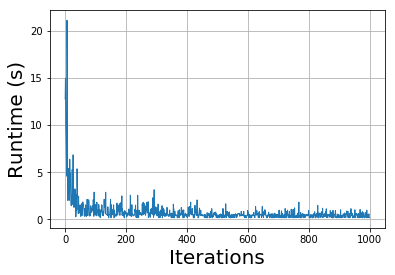

In [9]:
#plt.figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
plt.grid()
plt.ylabel('Runtime (s)', fontsize=20)
plt.xlabel('Iterations', fontsize=20)
plt.plot(runtime[:1000], linewidth= 1)
#plt.savefig('Cleanup/Runtime.png', dpi = 600, bbox_inches='tight')
plt.show()

In [10]:
from statistics import mean
mean(runtime)